In [1]:
from transformers import AutoProcessor, OwlViTForObjectDetection, AutoModelForZeroShotObjectDetection
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

c:\Users\s.srivastava\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def display_image(image):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [3]:
def display_bbox(boxes, image):
    """
    boxes: list of boxes, each box is a list of 4 numbers: x1, y1, x2, y2
    image: a numpy array of shape (m, n, 3), the target image
    """
    image = image.copy()
    # print(type(boxes[0][0]))
    # return
    for box in boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
    plt.axis('off')
    plt.imshow(image)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1281x698 at 0x25C60F161A0>


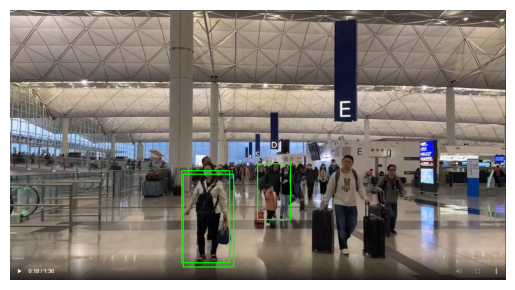

In [10]:
query = [['woman with black backpack']]

checkpoint = "google/owlvit-base-patch32"
image = Image.open('data/man_with_suitcase.jpg')
print(image)
processor = AutoProcessor.from_pretrained(checkpoint)
inputs = processor(text=query, images=image, return_tensors='pt')
model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
outputs = model(**inputs)

target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, threshold=0.05,target_sizes=target_sizes)

display_bbox(results[0]['boxes'].tolist(), np.array(image))